In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import os
import sys
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from PIL import Image
import cv2
import time

In [3]:
# Since this project deals with coordinates with respect to a camera, we need a conversion from pixels to real-world coordinates and vice-versa
f = 12                   # Focal length in mm
image_width = 2448       # Image width (resolution)
image_height = 2048      # Image height (resolution)
sensor_height = 8.4456   # Sensor height in mm
sensor_width = 7.0656    # Sensor width in mm
cx = image_width / 2     # Focal centre (at the origin)
cy = image_height / 2

fx = f * image_width / sensor_width
fy = f * image_height / sensor_height

# Camera matrix

K = np.array([[fx, 0, cx],
             [0, fy, cy],
             [0, 0, 1]], dtype = float)

In [4]:
def position_to_pixel(position, K):
    '''
    Function to project a 3D point to a pixel
        - position (np.array): 3D coordinates to be projected to pixel
    '''
    # cv2.projectPoints expects an array of shape (N,3) even if N=1
    position = np.array([position], dtype=np.float32).reshape(-1, 3)
    pixels, _ = cv2.projectPoints(position, np.zeros((3, 1), dtype=np.float32), np.zeros((3, 1), dtype=np.float32), K, distCoeffs=None)
    return pixels[0,0]

def pixel_to_position(pixel, z, K):
    '''
    Function to project a pixel to (x,y) coordinates. Z is required to be known
        - pixel (tuple (int, int)): 2D pixel position
    '''
    x = (pixel[0] - K[0,2]) * z / K[0,0]
    y = (pixel[1] - K[1,2]) * z / K[1,1]

    return np.array([x,y,z])
    

In [12]:
# First we initialize the dataset object
class CubeSat_Dataset(Dataset):

    def __init__(self, image_dir, label_file, mode = 'train', validation_split = (-1,-1), transform = None):
        '''
        Initialises the dataset object with the inputs:
            - image_file (str): path to file with images
            - label_file (str): path to file with labels
            - mode (str) indicates whether this loads the training or validation dataset
            - validation_split (tuple (float, int))
                validation_split[0] specifies the percentage of the data to be used for validation
                validation_split[1] specifies the random seed (needed for reproducibility to split two different  objects in the same way)
            if any of the two numbers are negative no split will be done
            - transform: transformation to apply to the data
        '''
        # Since for this project the loading of the data into memory is too demanding, the data is lazy loaded, i.e. the specific element is loaded on demand
        
        # We read the images and the labels, and check if they have the same length
        self.images = self.read_images(image_dir)
        self.labels = self.read_labels(label_file)
        if len(self.images)!=len(self.labels):
            raise Exception("Number of images and labels do not match")

        # We want to split the dataset to also get evaluation data
        if validation_split[0]>0 and validation_split[1]>0:
            # Note, i specify the random state in validation_split[1] for  reproducibility
            train_images, val_images, train_labels, val_labels = train_test_split(
                self.images, self.labels, test_size=validation_split[0], random_state=validation_split[1])

            # Depending on the mode we either save as attribute the training data or the testing data
            if mode == 'train':
                self.images = train_images
                self.labels = train_labels
                
            elif mode == 'val':
                self.images = val_images
                self.labels = val_labels

        self.transform = transform

    def __len__(self):
        '''
        Method for the length of the object
        '''
        return len(self.images)

    def __getitem__(self, idx):
        '''
        Method to extract an item from the object
            - idx: positional index of data within the object (i.e. within each array of images-labels)
        '''
        image = self.images[idx]      
        label = torch.tensor(self.labels[idx], dtype=torch.float32)

        # Apply the transformation if specified
        if self.transform:
            image = self.transform(image)

        return image, label

    def read_images(self, directory):
        '''
        Function to read in the images from the CubeSat dataset
            - directory (str): path to the images' directory
        '''
        image_files = sorted([f for f in os.listdir(directory) if f.endswith('.jpg')])[:50]
        images = [Image.open(os.path.join(directory,file)).convert('RGB') for file in image_files]
        # Return images. NOTE the ToTensor() pytorch transformation normalises the data
        return images

    def read_labels(self, filename):
        '''
        Function to read in the labels from the CubeSat dataset
            - filename (str): path to the data file, in .csv format
        '''
        labels = pd.read_csv(filename)
        labels = labels.iloc[:50, 1:7].values
        
        return labels



# First we initialize the dataset object
class CubeSat_Dataset(Dataset):

    def __init__(self, image_dir, label_file, mode = 'train', validation_split = (-1,-1), transform = None):
        '''
        Initialises the dataset object with the inputs:
            - image_file (str): path to file with images
            - label_file (str): path to file with labels
            - mode (str) indicates whether this loads the training or validation dataset
            - validation_split (tuple (float, int))
                validation_split[0] specifies the percentage of the data to be used for validation
                validation_split[1] specifies the random seed (needed for reproducibility to split two different  objects in the same way)
            if any of the two numbers are negative no split will be done
            - transform: transformation to apply to the data
        '''
        # Since for this project the loading of the data into memory is too demanding, the data is lazy loaded, i.e. the specific element is loaded on demand
        self.image_files = sorted([os.path.join(image_dir,f) for f in os.listdir(image_dir) if f.endswith('.jpg')])
        self.labels = pd.read_csv(label_file).iloc[:, 1:7].values

        # We want to split the dataset to also get evaluation data
        if validation_split[0]>0 and validation_split[1]>0:
            # Note, i specify the random state in validation_split[1] for  reproducibility
            train_image_files, val_image_files, train_labels, val_labels = train_test_split(
                self.image_files, self.labels, test_size=validation_split[0], random_state=validation_split[1])

            # Depending on the mode we either save as attribute the training data or the testing data
            if mode == 'train':
                self.image_files = train_image_files
                self.labels = train_labels
                
            elif mode == 'val':
                self.image_files = val_image_files
                self.labels = val_labels

        self.transform = transform

    def __len__(self):
        '''
        Method for the length of the object
        '''
        return len(self.image_files)

    def __getitem__(self, idx):
        '''
        Method to extract an item from the object
            - idx: positional index of data within the object (i.e. within each array of images-labels)
        '''

        # Apply the transformation if specified
        if self.transform:
            return self.transform(Image.open(self.image_files[idx]).convert('RGB')), torch.tensor(self.labels[idx], dtype=torch.float32)
            
        return Image.open(self.image_files[idx]).convert('RGB'), torch.tensor(self.labels[idx], dtype=torch.float32)
        

We have 7998 training images and 2000 testing images
See this example:


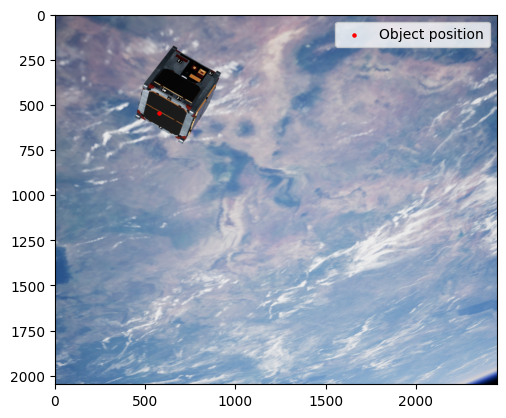

Real position: [-0.174484 -0.184005  1.116277]
Projected position: [574.12885 544.33466]
Reconstructed position: [-0.174484   -0.184005    1.11627698]
Reconstruction error: [3.76717471e-09 8.72096986e-09 0.00000000e+00]


In [6]:

# Paths to training images (these are from kaggle as they have GPUs available)
training_images = '/kaggle/input/synthetic-cubesat/synthetic_cubesat/dataset/train/images'
training_labels = '/kaggle/input/synthetic-cubesat/synthetic_cubesat/dataset/train/train_ground_truth.csv'
testing_images = '/kaggle/input/synthetic-cubesat/synthetic_cubesat/dataset/test/images'
testing_labels = '/kaggle/input/synthetic-cubesat/synthetic_cubesat/dataset/test/test_ground_truth.csv'

# Load in the training data with no transform for testing reasons to see if everything works correctly
training_data = CubeSat_Dataset(image_dir=training_images, label_file=training_labels,transform=None)
testing_data = CubeSat_Dataset(image_dir=testing_images, label_file=testing_labels,transform=None)

selected_example = training_data[3]
selected_example_pixel = position_to_pixel(selected_example[1].numpy()[:3],K)
selected_example_reconstructed = pixel_to_position(selected_example_pixel, selected_example[1].numpy()[2], K)

print(f"We have {len(training_data)} training images and {len(testing_data)} testing images")
print("See this example:")
plt.figure()
plt.imshow(selected_example[0])
plt.scatter([selected_example_pixel[0]],[selected_example_pixel[1]],color='r',s=5, label = 'Object position')
plt.legend()
plt.show()
plt.close()
print(f"Real position: {selected_example[1].numpy()[:3]}")
print(f"Projected position: {selected_example_pixel}")
print(f"Reconstructed position: {selected_example_reconstructed}")
print(f"Reconstruction error: {np.abs(selected_example_reconstructed-selected_example[1].numpy()[:3])}")

In [13]:
# Having checked everything is correct we initialize the data as a tensor

# Define validation split fraction and random seed for reproducibility
validation_split = (0.166,43)

# The transfrm includes resizing to save memory
transform = transforms.Compose([transforms.Resize(512),
                               transforms.ToTensor()])

# Define dataset objects
training_data = CubeSat_Dataset(image_dir=training_images, label_file=training_labels, validation_split = validation_split, mode = 'train', transform=transform)
validation_data = CubeSat_Dataset(image_dir=training_images, label_file=training_labels, validation_split = validation_split, mode = 'val', transform=transform)
testing_data = CubeSat_Dataset(image_dir=testing_images, label_file=testing_labels,transform=transform)

print(len(training_data))
print(len(validation_data))
print(len(testing_data))

# We batch the datasets and produce the data loader iterables
dataloader_training = DataLoader(training_data, batch_size = 32, shuffle = True)
dataloader_val = DataLoader(validation_data, batch_size = 32, shuffle = False)
dataloader_testing = DataLoader(testing_data, batch_size = 32, shuffle = False)

16
4
20


In [8]:
# THIS NETWORK IS FOR THE FULL RESOLUTION IMAGES WITHOUT DOWNSIZING THE RESOLUTION
# IT TURNS OUT TO BE TOO COMPUTATIONALLY EXPENSIVE

class CubeSat_Regression(nn.Module):
    def __init__(self, num_labels = 6, dropout_rate = 0.5):
        '''
        Initialises the network class inheriting everything from nn.Module from pytorch
            - num_labels (int): number of elements in the label for each image
            - dropout_rate (float): fraction of cells set to zero during dropout
        '''
        # Inherit the initialization from the superior class nn.Module
        super(CubeSat_Regression, self).__init__()

        # We now construct a sequence of convolutional-max pooling layers
        self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5),
            nn.MaxPool2d(kernel_size = 2),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2),
            nn.Dropout2d(p=dropout_rate),
            nn.MaxPool2d(kernel_size = 2),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2),
            nn.MaxPool2d(kernel_size = (3,2), stride = 2),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3,2), stride = 2),
            nn.ReLU()
        )

        # The result from the previous layers is now flattened (all the channels) and fed into a vanilla neural network:
        self.dense_layers = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(p=dropout_rate),
            nn.Linear(in_features=256*31*38, out_features=num_labels),
        )

    def forward(self,x):
        '''
        Method to feedforward from input to output of the layer
        '''
        return self.dense_layers(self.conv_layers(x))


# THIS CLASS IS FOR THE NEURAL NETWORK WITH THE DOWNSIZED RESOLUTION (TO 512 PIXELS ON ITS SHORTER SIDE)

class CubeSat_Regression(nn.Module):
    def __init__(self, num_labels = 6, dropout_rate = 0.5):
        '''
        Initialises the network class inheriting everything from nn.Module from pytorch
            - num_labels (int): number of elements in the label for each image
            - dropout_rate (float): fraction of cells set to zero during dropout
        '''
        # Inherit the initialization from the superior class nn.Module
        super(CubeSat_Regression, self).__init__()

        # We now construct a sequence of convolutional-max pooling layers
        self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5),
            nn.Dropout2d(p=dropout_rate),
            nn.MaxPool2d(kernel_size = 2),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5),
            nn.MaxPool2d(kernel_size = 2),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3,4), stride=2),
            nn.MaxPool2d(kernel_size = 2),
            nn.ReLU(),
        )

        # The result from the previous layers is now flattened (all the channels) and fed into a vanilla neural network:
        self.dense_layers = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(p=dropout_rate),
            nn.Linear(in_features=128*31*37, out_features=num_labels),
        )

    def forward(self,x):
        '''
        Method to feedforward from input to output of the layer
        '''
        return self.dense_layers(self.conv_layers(x))

In [9]:
def train(model, train_loader, val_loader = False, test_loader = False, num_epochs = 40, lr = 0.1, l2_lambda = 0.1, momentum=0.5, patience = 15):
    '''
    Function to train the model
        - model (class): Neural network object to be trained
        - train_loader (iterable): Iterable containing the training dataset (DataLoader)
        - val_loader, test_loader (iterable): Iterable containing the validation and testing datasets (DataLoader). If set to false, no validation/testing information will be extracted
        - num_epochs (int): maximum number of epochs
        - lr (float): Learning rate
        - l2_lambda (float): Weight decay 'lambda' parameter
        - momentum (float): momentum co-efficient parameter
        - patience (int): patience parameter for early stopping. Maximum number of epochs during which the validation loss has not improved in order to early stop.
    '''
    # Check if there is a gpu available for use. If not, use a cpu
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    # Define the loss function, the optimizer using the input parameters, and a learning rate decay scheduler
    criterion = nn.HuberLoss(delta=1)
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay = l2_lambda)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

    # Initialize empty lists of data
    train_losses, val_losses, test_losses = [], [], []

    # Counters for the early stopping
    patience_counter = 0
    best_val_loss = float('inf')

    # We loop over the epochs
    #for epoch in tqdm(range(num_epochs), desc = 'Epochs'):   I REMOVED THIS LINE BUT IT CAN BE USED TO SHOW A DYNAMIC BAR OF THE PROGRESS
    for epoch in range(num_epochs):
        # We will measure the runtime
        start_time = time.time()
        
        # Model into train mode
        model.train()

        # Initialize variables for loss calculations
        running_loss = 0.

        # Iterate over the items in the loader
        for inputs, labels in tqdm(train_loader, desc = 'Data'):
            # Move inputs and labels to the device (CPU or GPU)
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)                 # Feedforward the inputs to the outputs
            loss = criterion(outputs, labels)       # Calculate the loss
            optimizer.zero_grad()                   # Set the gradients to zero
            loss.backward()                         # Backpropagate the error
            optimizer.step()                        # Correct the parameters

            # We multiply the running loss by labels.size(0) (the batch size) because the loss function returns the average loss per sample in the batch. We calculate the actual loss and then we will average over the entire dataset
            running_loss += loss.item() * labels.size(0)
        
        # We calculate the average training loss of the whole dataset
        train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(train_loss)
        
        #################### Validation ##################################
        # If there is no validation set then we only print the training information
        if not val_loader and epoch%10==0:
            print(f"Epoch [{epoch+1} / {num_epochs}] done in {(time.time()-start_time)/60:.2f} s \nLoss on training data: {train_loss:.2f}")
            
        # If there is we perform a validation set study as well
        elif val_loader:
            # Model into evaluation mode
            model.eval()

            # Variables for the loss calculation
            running_loss = 0.

            # Disable gradient computation
            with torch.no_grad():
                # Loop over the data in the evaluation set and perform a process analogous to the testing case, without modifying the parameters
                for inputs, labels in val_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    
                    running_loss += loss.item() * labels.size(0)

            val_loss = running_loss / len(val_loader.dataset)
            val_losses.append(val_loss)

            # Print the results for the current epoch
            print(f"Epoch [{epoch+1} / {num_epochs}] done in {(time.time()-start_time)/60:.2f} s \nLoss on training data: {train_loss:.2f} \nLoss on validation data: {val_loss:.2f}")

            # Now we check if the loss is improving for the early stopping case
            if best_val_loss > val_loss:
                patience_counter = 0
                best_val_loss = val_loss
            else:
                patience_counter += 1

            if patience_counter >= patience:
                print(f"\nEarly stop at epoch {epoch + 1}\n")
                break
            
        # Advance the scheduler (i.e. evolve the learning rate)
        scheduler.step(val_loss)

        # Get the testing set current loss
        if test_loader:
            test_loss = test(model, test_loader)
            test_losses.append([epoch,test_loss])
    
    # Return the result
    return np.array(train_losses), np.array(val_losses), np.array(test_losses)
    

def test(model, test_loader):
    '''
    Function to calculate the loss of passing the testing data through the model
        - model (class): Neural network object to be trained
        - test_loader (iterable): Iterable containing the training dataset (DataLoader)
    '''
    # The process is analogous to the testing and validation cases above
    criterion = nn.HuberLoss(delta=1)
    
    model.eval()
    running_loss = 0.
    
    for inputs, labels in test_loader:
        
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        running_loss += loss.item() * labels.size(0)

    return  running_loss / len(test_loader.dataset)

In [14]:
# Define the model and the device
model = CubeSat_Regression(num_labels = 6, dropout_rate = 0.1)
from pympler import asizeof

print(asizeof.asizeof(model)/(1024**2))
print(asizeof.asizeof(dataloader_training)/(1024**2))
print(asizeof.asizeof(dataloader_val)/(1024**2))
print(asizeof.asizeof(dataloader_testing)/(1024**2))

0.0444488525390625
0.01001739501953125
0.00769805908203125
0.10230255126953125


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

# We train the model!
train_losses, val_losses, test_losses = train(
    model, dataloader_training, dataloader_val, dataloader_testing,
    num_epochs = 10, lr = 0.1, l2_lambda = 0.3, momentum=0.3, patience = 30)

# We calculate the testing accuracy of the resulting model